# I Prepare the Data for PC and Sensor

In [1]:
# import libraries
import math
import numpy as np
import os
import re
import csv
import pandas as pd
import random
import time
import scipy
from scipy.io import loadmat  # for loading matlab files

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

import plotly.graph_objects as go

In [2]:
# random seed, for consistency
np.random.seed(42)

In [3]:
# training data loading - input and output

# train input
train_input = loadmat('x_train.mat')
train_input = np.array(train_input['x_train'])
print(type(train_input),train_input.shape)

# train output
train_output = loadmat('y_train.mat')
train_output = np.array(train_output['y_train'])
print(type(train_output),train_output.shape)

# test data loading - input and ground truth output, predicted output is to be generated by GPR model

prediction_input = loadmat('x_test.mat')
prediction_input = np.array(prediction_input['x_test'])
print(type(prediction_input),prediction_input.shape)

prediction_groundtruth = loadmat('y_testtrue.mat')
prediction_groundtruth = np.array(prediction_groundtruth['y'])
print(type(prediction_groundtruth),prediction_groundtruth.shape)

<class 'numpy.ndarray'> (215, 2)
<class 'numpy.ndarray'> (215, 1)
<class 'numpy.ndarray'> (147, 2)
<class 'numpy.ndarray'> (147, 1)


In [4]:
NUM_TRAIN = 30
NUM_PRED = 10

# pick NUM_TRAIN random samples from 1 to 215, then pick from train_input and train_output according to these indices
random.seed(42)
train_indices = random.sample(range(215), NUM_TRAIN)
train_indices.sort()
print(train_indices)

TRAIN_IN = train_input[train_indices]
TRAIN_OUT = train_output[train_indices]

# print the TRAIN_IN
print("TRAIN_IN:")
print(TRAIN_IN)

# print the TRAIN_OUT
print("TRAIN_OUT:")
print(TRAIN_OUT)


[6, 7, 8, 22, 23, 26, 28, 35, 50, 55, 57, 59, 62, 70, 108, 129, 139, 143, 151, 154, 163, 166, 173, 179, 183, 188, 189, 202, 211, 212]
TRAIN_IN:
[[-1.41182449  0.00620905]
 [-2.4503275   0.00652449]
 [ 1.27331391  0.00684317]
 [-1.6831451   0.01236047]
 [ 0.86165506  0.01237232]
 [-1.41182449  0.01263619]
 [ 0.09447266  0.01302913]
 [ 0.37514915  0.01345154]
 [ 0.74938446  0.01456382]
 [-0.93467446  0.01492926]
 [ 0.22545502  0.01518825]
 [-0.50430385  0.01522429]
 [ 1.4417198   0.01529268]
 [-0.58850679  0.01583067]
 [-0.15813618  0.01877276]
 [ 1.78788747  0.02068833]
 [ 1.03941684  0.02186123]
 [-0.79433622  0.02275043]
 [-0.05522147  0.02428302]
 [ 0.77745211  0.02456357]
 [-0.58850679  0.02758599]
 [ 1.23589038  0.02775411]
 [ 0.786808    0.02835345]
 [ 0.59969034  0.02905677]
 [-0.30783031  0.02939415]
 [-0.67270974  0.02996821]
 [-0.67270974  0.02998274]
 [-0.5323715   0.03296531]
 [-0.26105089  0.03420586]
 [ 0.04769325  0.03435222]]
TRAIN_OUT:
[[0.01138038]
 [0.01265277]
 [0.00

In [5]:
# pick NUM_PRED random samples from 1 to 147, then pick from prediction_input and prediction_groundtruth according to these indices
random.seed(42)
prediction_indices = random.sample(range(147), NUM_PRED)
prediction_indices.sort()
print(prediction_indices)

PRED_IN = prediction_input[prediction_indices]
PRED_GT = prediction_groundtruth[prediction_indices]

# print the PRED_IN
print("PRED_IN:")
print(PRED_IN)

# print the PRED_GT
print("PRED_GT:")
print(PRED_GT)


[6, 22, 26, 28, 35, 57, 62, 70, 108, 139]
PRED_IN:
[[ 1.49004228  0.01433778]
 [ 0.80417027  0.01407253]
 [ 0.93219971  0.01408152]
 [ 1.782681    0.01680967]
 [ 1.75524612  0.01631756]
 [ 0.48409667  0.01024582]
 [ 0.78588035  0.01662556]
 [ 0.46580675  0.02132585]
 [ 0.25547267  0.01507037]
 [-1.38147519  0.01795533]]
PRED_GT:
[[0.02607182]
 [0.02419905]
 [0.02584306]
 [0.03654348]
 [0.04052737]
 [0.01461879]
 [0.03202451]
 [0.04619669]
 [0.03942593]
 [0.04068792]]


In [6]:
def save_as_c_array(data, filename):
    """
    save data as c array in txt files

    parameters:
    data: numpy array, data to save
    filename: str, file name
    """
    with open(filename, 'w') as file:
        file.write("int data[][] = {\n")
        for row in data:
            file.write("    {")
            file.write(", ".join(map(str, row)))
            file.write("},\n")
        file.write("};\n")

In [7]:
# save TRAIN_IN, TRAIN_OUT, PRED_IN, PRED_GT to .txt files, for C script to copy to 2D arrays

save_as_c_array(TRAIN_IN, 'TRAIN_IN.txt')
save_as_c_array(TRAIN_OUT, 'TRAIN_OUT.txt')
save_as_c_array(PRED_IN, 'PRED_IN.txt')
save_as_c_array(PRED_GT, 'PRED_GT.txt')

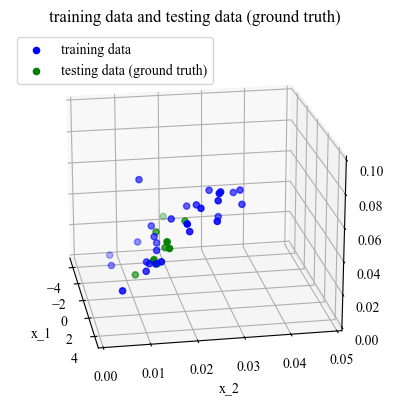

In [8]:
# check the data for training and testing

fig_dc = plt.figure()
ax_dc = fig_dc.add_subplot(111, projection = '3d')

# plot the data
ax_dc.scatter(TRAIN_IN[:, 0], TRAIN_IN[:, 1], TRAIN_OUT, c = 'blue',label = 'training data')
ax_dc.scatter(PRED_IN[:, 0], PRED_IN[:, 1], PRED_GT, c = 'green',label = 'testing data (ground truth)')

# set the limits for the plots
ax_dc.set_xlim(-5, 5)
ax_dc.set_ylim(0, 0.05)
ax_dc.set_zlim(0, 0.1)

# set the labels and titles for the plots
ax_dc.set_xlabel('x_1')
ax_dc.set_ylabel('x_2')
ax_dc.set_zlabel('y')
ax_dc.set_title('training data and testing data (ground truth)')

# add legends for the plots
plt.legend(loc = 'upper left')

# view
ax_dc.view_init(20, -10)

# Show the plot
plt.show()

# II PC COMPUTATION

In [9]:
# hyperparameters
RBF_Amplitude = 1
RBF_LengthScale = [5,0.2]
noise_lvl = 0.0004

# other parameters
RBF_Coef = 0.5

In [10]:
def gpr_kernel(PntA, PntB, RBF_Amplitude, RBF_LenScale, RBF_Coef):
    DIM_GPR_IN = len(PntA)
    AB_Diff = np.zeros(DIM_GPR_IN)
    
    # Calculate the difference between PntA and PntB
    K_Unit = 0
    for ind_t in range(DIM_GPR_IN):
        AB_Diff[ind_t] = PntA[ind_t] - PntB[ind_t]
        K_Unit += AB_Diff[ind_t] * AB_Diff[ind_t] / (RBF_LenScale[ind_t] * RBF_LenScale[ind_t])
    
    # Calculate the kernel function
    K_Unit = RBF_Amplitude * RBF_Amplitude * np.exp(-RBF_Coef * K_Unit)
    return K_Unit

In [11]:
# compute the kernel matrix Ktt, Kttn, Kpt, Kpt, Kpp

# Ktt
Ktt = np.zeros((NUM_TRAIN, NUM_TRAIN))
for ind_t in range(NUM_TRAIN):
    for ind_tt in range(NUM_TRAIN):
        Ktt[ind_t, ind_tt] = gpr_kernel(TRAIN_IN[ind_t], TRAIN_IN[ind_tt], RBF_Amplitude, RBF_LengthScale, RBF_Coef)

# Kttn - add noise to the diagonal of Ktt
Kttn = Ktt + noise_lvl * np.eye(NUM_TRAIN)

# print the last 3 rows and cols of Kttn
print("Kttn:")
print(Kttn[-3:, -3:])

Kttn:
[[1.0004     0.99850958 0.99326921]
 [0.99850958 1.0004     0.99809509]
 [0.99326921 0.99809509 1.0004    ]]


In [12]:
# Kpt
Kpt = np.zeros((NUM_PRED, NUM_TRAIN))
for ind_p in range(NUM_PRED):
    for ind_t in range(NUM_TRAIN):
        Kpt[ind_p, ind_t] = gpr_kernel(PRED_IN[ind_p], TRAIN_IN[ind_t], RBF_Amplitude, RBF_LengthScale, RBF_Coef)

# print the last 3 rows and colums of Kpt
print("Kpt")
print(Kpt[-3:, -3:])

Kpt
[[0.97861139 0.98743943 0.99439829]
 [0.98371719 0.99013595 0.99450434]
 [0.9829119  0.97199171 0.9567519 ]]


In [13]:
# Ktp
Ktp = np.zeros((NUM_TRAIN, NUM_PRED))
for ind_t in range(NUM_TRAIN):
    for ind_p in range(NUM_PRED):
        Ktp[ind_t, ind_p] = gpr_kernel(TRAIN_IN[ind_t], PRED_IN[ind_p], RBF_Amplitude, RBF_LengthScale, RBF_Coef)

# print the last 3 rows and colums of Ktp
print("Ktp")
print(Ktp[-3:, -3:])

Ktp
[[0.97861139 0.98371719 0.9829119 ]
 [0.98743943 0.99013595 0.97199171]
 [0.99439829 0.99450434 0.9567519 ]]


In [14]:
# Kpp
Kpp = np.zeros((NUM_PRED, NUM_PRED))

for ind_p in range(NUM_PRED):
    for ind_pp in range(NUM_PRED):
        Kpp[ind_p, ind_pp] = gpr_kernel(PRED_IN[ind_p], PRED_IN[ind_pp], RBF_Amplitude, RBF_LengthScale, RBF_Coef)
        
# print the last 3 rows and colums of Kpp
print("Kpp")
print(Kpp[-3:, -3:])


Kpp
[[1.         0.998627   0.93389523]
 [0.998627   1.         0.94772017]
 [0.93389523 0.94772017 1.        ]]


In [15]:
# GAUSS JORDAN INVERSE - to be consistent with CMSIS-DSP library
def gauss_jordan_inverse(matrix):
    n = len(matrix)
    identity_matrix = np.eye(n)
    augmented_matrix = np.hstack((matrix, identity_matrix))

    for i in range(n):
        # 使对角线元素为1
        factor = augmented_matrix[i, i]
        augmented_matrix[i] = augmented_matrix[i] / factor
        
        # 使该列的其他元素为0
        for j in range(n):
            if i != j:
                factor = augmented_matrix[j, i]
                augmented_matrix[j] = augmented_matrix[j] - factor * augmented_matrix[i]

    inverse_matrix = augmented_matrix[:, n:]
    return inverse_matrix

In [16]:
# Invert Kttn - IKttn
# IKttn = np.linalg.inv(Kttn)
IKttn = gauss_jordan_inverse(Kttn)

# print the last 3 rows and colums of IKttn
print("IKttn")
print(IKttn[-3:, -3:])


IKttn
[[2080.84111645 -361.89571479 -270.8191812 ]
 [-361.89571479 2133.2592174  -339.3929229 ]
 [-270.8191812  -339.3929229  2116.2429016 ]]


In [17]:
# mean of y_testtrue - scalar
mean_PRED_OUT = np.mean(TRAIN_OUT)

# print the mean of PRED_OUT = mean OF TRAIN_OUT
print("mean_PRED_OUT")
print(mean_PRED_OUT)

mean_PRED_OUT
0.04024688190526749


In [18]:
KptxIKttn = Kpt @ IKttn

# print the last 3 rows and colums of KptxIKttn
print("KptxIKttn")
print(KptxIKttn[-3:, -3:])

KptxIKttn
[[ 0.00126974  0.02525725  0.05132294]
 [-0.02339419 -0.00957453  0.00627552]
 [ 0.08247895  0.03372709 -0.01426821]]


In [19]:
# PRED_OUT = mean_PRED_OUT + KptxIKttn @ (TRAIN_OUT - mean_PRED_OUT)

PRED_OUT = mean_PRED_OUT + KptxIKttn @ (TRAIN_OUT - mean_PRED_OUT)

# print all values of PRED_OUT
print("PRED_OUT")
print(PRED_OUT)

PRED_OUT
[[0.02856014]
 [0.02527712]
 [0.02538079]
 [0.0370133 ]
 [0.03559671]
 [0.01824715]
 [0.03038375]
 [0.03965582]
 [0.02845743]
 [0.03983696]]


In [20]:
# PRED_OUT_VAR_MAT = Kpp - KptxIKttn @ Ktp

PRED_OUT_VAR_MAT = Kpp - KptxIKttn @ Ktp

# print the last 3 rows and colums of PRED_OUT_VAR_MAT
print("PRED_OUT_VAR_MAT")
print(PRED_OUT_VAR_MAT[-3:, -3:])

PRED_OUT_VAR_MAT
[[ 3.22246587e-05  3.08811423e-05 -1.20829642e-05]
 [ 3.08811411e-05  4.37462915e-05 -7.27247760e-06]
 [-1.20829645e-05 -7.27247662e-06  6.62968678e-05]]


In [21]:
# take the diagonal of PRED_OUT_VAR_MAT to get PRED_OUT_VAR

PRED_OUT_VAR = np.diag(PRED_OUT_VAR_MAT).reshape(-1, 1)

# print the all values of PRED_OUT_VAR
print("PRED_OUT_VAR")

print(PRED_OUT_VAR)


PRED_OUT_VAR
[[1.01692472e-04]
 [4.66694758e-05]
 [4.79477609e-05]
 [1.98457319e-04]
 [1.86040154e-04]
 [6.98400805e-05]
 [3.72881258e-05]
 [3.22246587e-05]
 [4.37462915e-05]
 [6.62968678e-05]]


In [22]:
# get PRED_OUT_STD = sqrt(PRED_OUT_VAR)

PRED_OUT_STD = np.sqrt(PRED_OUT_VAR)

# print the all values of PRED_OUT_STD
print("PRED_OUT_STD")
print(PRED_OUT_STD)


PRED_OUT_STD
[[0.01008427]
 [0.00683151]
 [0.00692443]
 [0.01408749]
 [0.01363965]
 [0.00835704]
 [0.0061064 ]
 [0.00567668]
 [0.0066141 ]
 [0.00814229]]


In [23]:
PRED_OUT_UB = PRED_OUT + 2 * PRED_OUT_STD
PRED_OUT_LB = PRED_OUT - 2 * PRED_OUT_STD

# print the all values of PRED_OUT_UB
print("PRED_OUT_UB")
print(PRED_OUT_UB)

# print the all values of PRED_OUT_LB
print("PRED_OUT_LB")
print(PRED_OUT_LB)

PRED_OUT_UB
[[0.04872868]
 [0.03894013]
 [0.03922965]
 [0.06518828]
 [0.06287602]
 [0.03496122]
 [0.04259655]
 [0.05100917]
 [0.04168562]
 [0.05612154]]
PRED_OUT_LB
[[0.0083916 ]
 [0.01161411]
 [0.01153192]
 [0.00883833]
 [0.0083174 ]
 [0.00153307]
 [0.01817095]
 [0.02830247]
 [0.01522923]
 [0.02355238]]


In [24]:
# STD OF TRAIN_OUT
std_TRAIN_OUT = np.std(TRAIN_OUT)

# III PC VISUALIZATION

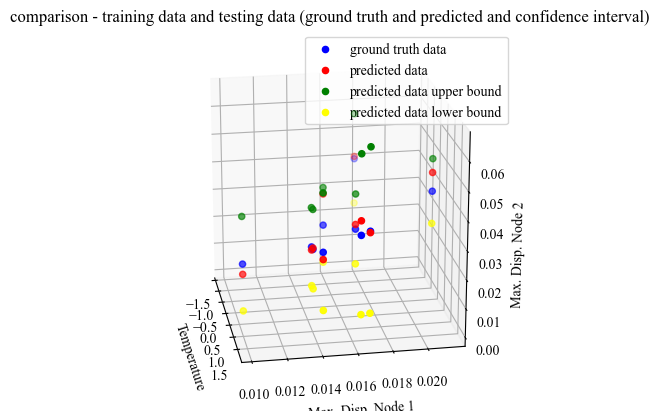

In [25]:
# visualize the data and confidence interval - 3D

# check generated data for testing
fig_gpr = plt.figure()
ax_gpr = fig_gpr.add_subplot(111, projection='3d')
# ax_gpr.scatter(x_train[:, 0], x_train[:, 1], y_train, c = 'black',label = 'training data')
ax_gpr.scatter(PRED_IN[:, 0], PRED_IN[:, 1], PRED_OUT, c = 'blue',label = 'ground truth data')
ax_gpr.scatter(PRED_IN[:, 0], PRED_IN[:, 1], PRED_GT, c = 'red',label = 'predicted data')
ax_gpr.scatter(PRED_IN[:, 0], PRED_IN[:, 1], PRED_OUT_UB, c = 'green',label = 'predicted data upper bound')
ax_gpr.scatter(PRED_IN[:, 0], PRED_IN[:, 1], PRED_OUT_LB, c = 'yellow',label = 'predicted data lower bound')

# # set the limits for the plots
# ax_gpr.set_xlim(-5, 5)
# ax_gpr.set_ylim(0, 0.05)
# ax_gpr.set_zlim(0, 0.05)

# set the labels and titles for the plots
ax_gpr.set_xlabel('Temperature')
ax_gpr.set_ylabel('Max. Disp. Node 1')
ax_gpr.set_zlabel('Max. Disp. Node 2')
ax_gpr.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# add legends for the plots
plt.legend(loc = 'best')

# view
# ax_gpr.view_init(30, 30)
ax_gpr.view_init(20, -10)

# perspective mode setup
ax_gpr.set_box_aspect([1,1,1])

# Show the plot
plt.show()

# print(max(y_testpred))

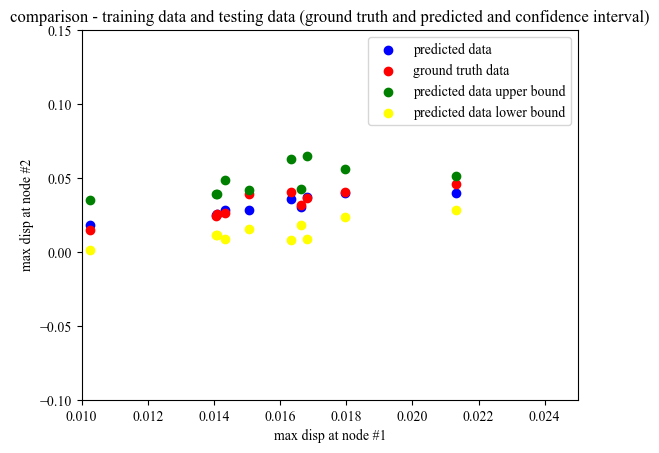

In [26]:
# 2D analysis - recall that the physical meaning is to use one pier max disp to predict the other

fig_gpr2d = plt.figure()
ax_gpr2d = fig_gpr2d.add_subplot(111)

# ax_gpr2d.scatter(x_train[:,1], y_train, c = 'black',label = 'training data')
ax_gpr2d.scatter(PRED_IN[:,1], PRED_OUT, c = 'blue',label = 'predicted data')
ax_gpr2d.scatter(PRED_IN[:,1], PRED_GT, c = 'red',label = 'ground truth data')
ax_gpr2d.scatter(PRED_IN[:,1], PRED_OUT_UB, c = 'green',label = 'predicted data upper bound')
ax_gpr2d.scatter(PRED_IN[:,1], PRED_OUT_LB, c = 'yellow',label = 'predicted data lower bound')

ax_gpr2d.set_xlim(0.01, 0.025)
ax_gpr2d.set_ylim(-0.10, 0.15)

# set the labels and titles for the plots
ax_gpr2d.set_xlabel('max disp at node #1')
ax_gpr2d.set_ylabel('max disp at node #2')
ax_gpr2d.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# add legends for the plots
plt.legend(loc = 'best')

# Show the plot
plt.show()


# IV SENSOR COMPUTATION

In [27]:
x_test = PRED_IN
y_testpred = PRED_OUT
y_testtrue = PRED_GT

In [28]:
# NOTE: these data are copied from sensor nodes

# generated data for prediction
y_testpred = [    0.028628,    0.025330,    0.025440,    0.037061,    0.035631,    0.018307,    0.030439,    0.039715,    0.028511,    0.039895]

std_testpred = [0.050433,    0.050302,    0.050374,    0.050184,    0.050008,    0.044085,    0.044873,    0.043471,    0.044924,    0.045227]

y_testpred_ub = [y_testpred[i] + 2*std_testpred[i] for i in range(NUM_PRED)]

y_testpred_lb = [y_testpred[i] - 2*std_testpred[i] for i in range(NUM_PRED)]

# V SENSOR VISUALIZATION

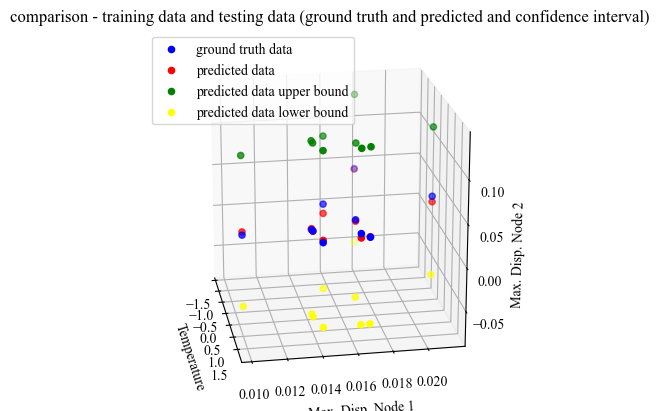

In [29]:
# visualize the data and confidence interval - 3D

# check generated data for testing
fig_gpr = plt.figure()
ax_gpr = fig_gpr.add_subplot(111, projection='3d')
# ax_gpr.scatter(x_train[:, 0], x_train[:, 1], y_train, c = 'black',label = 'training data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testtrue, c = 'blue',label = 'ground truth data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred, c = 'red',label = 'predicted data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred_ub, c = 'green',label = 'predicted data upper bound')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred_lb, c = 'yellow',label = 'predicted data lower bound')


# # set the limits for the plots
# ax_gpr.set_xlim(-5, 5)
# ax_gpr.set_ylim(0, 0.05)
# ax_gpr.set_zlim(0, 0.05)

# set the labels and titles for the plots
ax_gpr.set_xlabel('Temperature')
ax_gpr.set_ylabel('Max. Disp. Node 1')
ax_gpr.set_zlabel('Max. Disp. Node 2')
ax_gpr.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# add legends for the plots
plt.legend(loc = 'best')

# view
# ax_gpr.view_init(30, 30)
ax_gpr.view_init(20, -10)

# perspective mode setup
ax_gpr.set_box_aspect([1,1,1])

# Show the plot
plt.show()

# print(max(y_testpred))

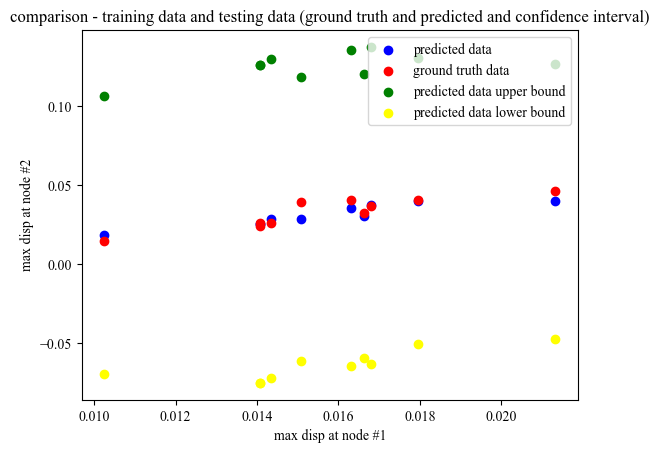

In [30]:
# 2D analysis - recall that the physical meaning is to use one pier max disp to predict the other

fig_gpr2d = plt.figure()
ax_gpr2d = fig_gpr2d.add_subplot(111)

# ax_gpr2d.scatter(x_train[:,1], y_train, c = 'black',label = 'training data')
ax_gpr2d.scatter(x_test[:,1], y_testpred, c = 'blue',label = 'predicted data')
ax_gpr2d.scatter(x_test[:,1], y_testtrue, c = 'red',label = 'ground truth data')
ax_gpr2d.scatter(x_test[:,1], y_testpred_ub, c = 'green',label = 'predicted data upper bound')
ax_gpr2d.scatter(x_test[:,1], y_testpred_lb, c = 'yellow',label = 'predicted data lower bound')

# # fill the confidence interval
# fill_x = np.concatenate([x_test[:,1], x_test[:,1]],axis = 0)
# fill_y = np.concatenate([y_testpred_ub[:,0], y_testpred_lb[:,0]],axis = 0)
# fill_x, fill_y = zip(*sorted(zip(fill_x, fill_y)))
# tri = Delaunay(np.array([fill_x, fill_y]).T)
# plt.triplot(fill_x, fill_y, tri.simplices, color='blue', alpha=0.2)
# plt.fill(fill_x, fill_y, color='purple', alpha=0.2)

# set the labels and titles for the plots
ax_gpr2d.set_xlabel('max disp at node #1')
ax_gpr2d.set_ylabel('max disp at node #2')
ax_gpr2d.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# add legends for the plots
plt.legend(loc = 'best')

# Show the plot
plt.show()

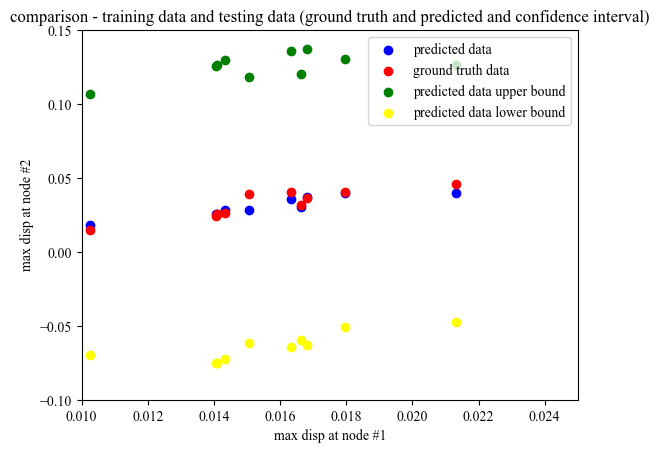

In [31]:
import matplotlib.pyplot as plt

fig_gpr2d = plt.figure()
ax_gpr2d = fig_gpr2d.add_subplot(111)

# 数据点的散点图
ax_gpr2d.scatter(x_test[:,1], y_testpred, c='blue', label='predicted data')
ax_gpr2d.scatter(x_test[:,1], y_testtrue, c='red', label='ground truth data')
ax_gpr2d.scatter(x_test[:,1], y_testpred_ub, c='green', label='predicted data upper bound')
ax_gpr2d.scatter(x_test[:,1], y_testpred_lb, c='yellow', label='predicted data lower bound')

# 设置坐标轴范围
# x_min = 0.01  # 用户定义的 x 轴最小值
# x_max = 0.03  # 用户定义的 x 轴最大值
# y_min = -0.05  # 用户定义的 y 轴最小值
# y_max = 0.15  # 用户定义的 y 轴最大值
ax_gpr2d.set_xlim(0.01, 0.025)
ax_gpr2d.set_ylim(-0.10, 0.15)

# 设置标签和标题
ax_gpr2d.set_xlabel('max disp at node #1')
ax_gpr2d.set_ylabel('max disp at node #2')
ax_gpr2d.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# 添加图例
plt.legend(loc='best')

# 显示图像
plt.show()

# VI GRAPH

In [32]:
# use plotly to visualize the data and confidence interval - 2D

fig_gpr2d = go.Figure()

# font setting, font times new roman, size 12, bold
fig_gpr2d.update_layout(font = dict(family = 'Times New Roman', size = 16, color = 'black'))

# limit the x-axis and y-axis
xmin = 0.01
xmax = 0.025
ymin = -0.10
ymax = 0.15
fig_gpr2d.update_layout(xaxis=dict(range=[0.01, 0.024]))
fig_gpr2d.update_layout(yaxis=dict(range=[-0.10, 0.15]))

# margins
fig_gpr2d.update_layout(margin=dict(l=40, r=40, t=30, b=20))

# background color
fig_gpr2d.update_layout(paper_bgcolor="white")

# plot background color
fig_gpr2d.update_layout(plot_bgcolor="rgba(0,0,0,0)")

# fig_gpr2d.update_layout(
#     # Set font family and size for all text elements
#     font = dict(family = 'Times New Roman', size = 16, color = 'black'),

#     # Set margins around the plot
#     margin=dict(l=40, r=40, t=30, b=20),

#     # Set background color to white
#     paper_bgcolor="white",

#     # Set plot background color to transparent (no background fill)
#     plot_bgcolor="rgba(0,0,0,0)",

#     # Set x-axis title
#     xaxis=dict(
#         title=dict(text="X-Axis Title", font=dict(size=12)),
#         showline=True,
#         linewidth=1,
#         tickfont=dict(size=10),
#         tickmode="linear",
#         tick0=0,
#         dtick=1,
#         range=[xmin, xmax],  # Set x-axis range
#     ),

#     # Set y-axis title
#     yaxis=dict(
#         title=dict(text="Y-Axis Title", font=dict(size=12)),
#         showline=True,
#         linewidth=1,
#         tickfont=dict(size=10),
#         tickmode="linear",
#         tick0=0,
#         dtick=1,
#         range=[ymin, ymax],  # Set y-axis range
#     ),

#     # # Add legend (if needed)
#     # legend=dict(
#     #     orientation="h",
#     #     justification="left",
#     #     bordercolor="gray",
#     #     borderwidth=1,
#     #     font=dict(size=10),
#     #     xanchor=0.5,
#     #     yanchor="top",
#     #     x=0.01,
#     #     y=1,
#     # ),
# )

# add the ground truth data
fig_gpr2d.add_trace(go.Scatter(x = PRED_IN[:, 1], y = PRED_GT[:, 0], mode = 'markers', name = 'ground truth', marker = dict(color = 'red')))

# add the predicted data
fig_gpr2d.add_trace(go.Scatter(x = PRED_IN[:, 1], y = PRED_OUT[:, 0], mode = 'markers', name = 'prediction', marker = dict(color = 'blue')))

# add upper bound from PC
fig_gpr2d.add_trace(go.Scatter(x = PRED_IN[:, 1], y = PRED_OUT_UB[:, 0], mode = 'markers', name = 'upper bound (PC)', marker = dict(color = 'green')))

# add lower bound from PC
fig_gpr2d.add_trace(go.Scatter(x = PRED_IN[:, 1], y = PRED_OUT_LB[:, 0], mode = 'markers', name = 'lower bound (PC)', marker = dict(color = 'magenta')))

# add upper bound from sensor
fig_gpr2d.add_trace(go.Scatter(x = PRED_IN[:, 1], y = y_testpred_ub, mode = 'markers', name = 'upper bound (sensor))', marker = dict(color = 'purple')))

# add lower bound from sensor
fig_gpr2d.add_trace(go.Scatter(x = PRED_IN[:, 1], y = y_testpred_lb, mode = 'markers', name = 'lower bound (sensor)', marker = dict(color = 'orange')))

# show the plot
fig_gpr2d.show()

In [33]:
# sort data for plotting
# PRED_IN is sorted by the second column
sort_indices = np.argsort(PRED_IN[:, 1])



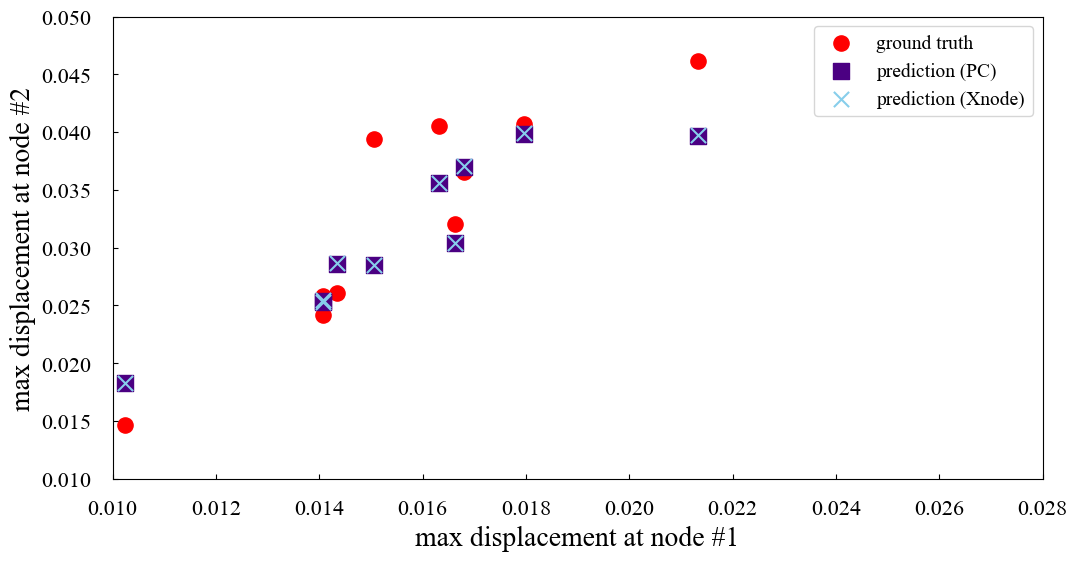

In [34]:
fig_gpr = plt.figure()

# Set font size globally (affects all text elements)
plt.rcParams['font.size'] = 16  # You can adjust this value as needed

# change the figure size to 16x10 inches
fig_gpr.set_size_inches(12, 6)

# subplot 1
ax_gpr = fig_gpr.add_subplot(111)

# axes setup
ax_gpr.tick_params(axis='both', direction='in', pad=15)

# plot the data
## ground truth
ax_gpr.scatter(PRED_IN[:,1], PRED_GT[:,0], marker='o', color='red', label='ground truth', s=120)
    
## predicted data - PC
ax_gpr.scatter(PRED_IN[:,1], PRED_OUT[:,0], marker='s', color='indigo', label='prediction (PC)', s=120)

# ## upper bound - PC
# ax_gpr.scatter(PRED_IN[:,1], PRED_OUT_UB[:,0], marker='^', color='indigo', label='upper bound (PC)', s=80)

# ## lower bound - PC
# ax_gpr.scatter(PRED_IN[:,1], PRED_OUT_LB[:,0], marker='v', color='indigo', label='lower bound (PC)', s=80)

## predicted data - sensor
ax_gpr.scatter(PRED_IN[:,1], y_testpred, marker='x', color='skyblue', label='prediction (Xnode)', s=120)

# ## upper bound - sensor
# ax_gpr.scatter(PRED_IN[:,1], y_testpred_ub, marker='^', color='skyblue', label='upper bound (sensor)', s=80)

# ## lower bound - sensor
# ax_gpr.scatter(PRED_IN[:,1], y_testpred_lb, marker='v', color='skyblue', label='lower bound (sensor)', s=80)
    
# axes limits
ax_gpr.set_xlim(0.01, 0.028)
ax_gpr.set_ylim(0.01, 0.05)

# titles and axis labels
ax_gpr.set_xlabel('max displacement at node #1', fontsize=20)
ax_gpr.set_ylabel('max displacement at node #2', fontsize=20)
# ax_gpr.set_title('comparison - PC vs Sensor Data')

# legend
plt.legend(loc='best', fontsize=14)

# 显示图像
plt.show()

# save as png
fig_gpr.savefig('comparison_PC_vs_sensor_data.png', dpi=300, bbox_inches='tight')

In [35]:
# save the lower bound, upper bound, from PC, and sensor to a txt

# convert y_testpred_ub and y_testpred_lb to numpy array
y_testpred_ub = np.array(y_testpred_ub).reshape(-1, 1)
y_testpred_lb = np.array(y_testpred_lb).reshape(-1, 1)

# check the shape of PRED_IN_UB, PRED_IN_LB, y_testpred_ub, y_testpred_lb
print(PRED_OUT_UB.shape)
print(PRED_OUT_LB.shape)
print(y_testpred_ub.shape)
print(y_testpred_lb.shape)

# concatenate PRED_OUT_UB, PRED_OUT_LB, y_testpred_ub, y_testpred_lb
confidence_interval = np.concatenate((PRED_OUT_LB, PRED_OUT_UB, y_testpred_lb, y_testpred_ub), axis=1)

# save to txt
np.savetxt('confidence_interval.txt', confidence_interval, delimiter=',', fmt='%.6f')

# save to xls
df = pd.DataFrame(confidence_interval,columns=['PC-LB', 'PC-UB', 'SENSOR-LB', 'SENSOR-UB'])
df.to_excel('confidence_interval.xlsx', header=False, index=False)

(10, 1)
(10, 1)
(10, 1)
(10, 1)


In [36]:
# SPC data

# from 1 - 10
num_sample = np.arange(1, 11)
print(num_sample)

# residual - PC
residual_PC = PRED_GT - PRED_OUT
print(residual_PC)

# convert y_testpred to numpy array
y_testpred = np.array(y_testpred).reshape(-1, 1)

# residual - sensor
residual_sensor = PRED_GT - y_testpred
print(residual_sensor)

# train_std = np.std(TRAIN_OUT)
train_std = np.std(PRED_GT - PRED_OUT)

# 2sigma_upper = 2 * train_std
two_sigma_upper = 2 * train_std

# 2sigma_lower = -2 * train_std
two_sigma_lower = -2 * train_std

# 3sigma_upper = 3 * train_std
three_sigma_upper = 3 * train_std

# 3sigma_lower = -3 * train_std
three_sigma_lower = -3 * train_std

[ 1  2  3  4  5  6  7  8  9 10]
[[-0.00248832]
 [-0.00107807]
 [ 0.00046227]
 [-0.00046983]
 [ 0.00493066]
 [-0.00362836]
 [ 0.00164076]
 [ 0.00654087]
 [ 0.0109685 ]
 [ 0.00085096]]
[[-0.00255618]
 [-0.00113095]
 [ 0.00040306]
 [-0.00051752]
 [ 0.00489637]
 [-0.00368821]
 [ 0.00158551]
 [ 0.00648169]
 [ 0.01091493]
 [ 0.00079292]]


In [37]:
# anomaly points
anomaly_points = np.where((residual_PC > two_sigma_upper) | (residual_PC < two_sigma_lower))



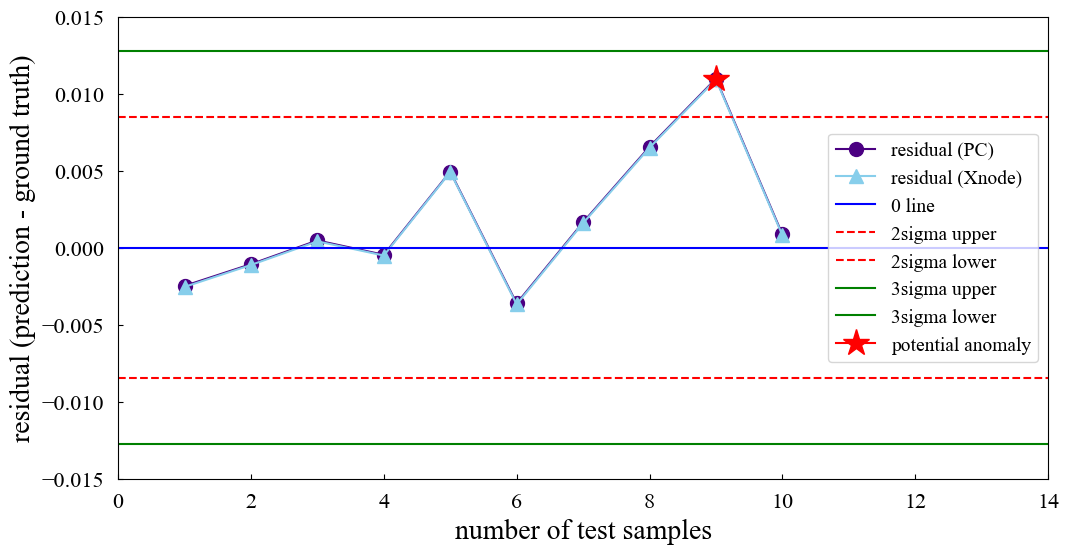

In [38]:
fig_spc = plt.figure()

# Set font size globally (affects all text elements)
plt.rcParams['font.size'] = 16  # You can adjust this value as needed

# change the figure size to 16x10 inches
fig_spc.set_size_inches(12, 6)

# subplot 1
ax_spc = fig_spc.add_subplot(111)

# axes setup
ax_spc.tick_params(axis='both', direction='in', pad=10)

# plot the data
## residual - PC
ax_spc.plot(num_sample, residual_PC, marker='o', color='indigo', label='residual (PC)', markersize=10)

## residual - sensor
ax_spc.plot(num_sample, residual_sensor, marker='^', color='skyblue', label='residual (Xnode)', markersize=10)

## 0 line
ax_spc.axhline(y=0, color='blue', linestyle='-', label='0 line')

## upper control limit - two sigma
ax_spc.axhline(y=two_sigma_upper, color='red', linestyle='--', label='2sigma upper')

## lower control limit - two sigma
ax_spc.axhline(y=two_sigma_lower, color='red', linestyle='--', label='2sigma lower')

## upper control limit - three sigma
ax_spc.axhline(y=three_sigma_upper, color='green', linestyle='-', label='3sigma upper')

## lower control limit - three sigma
ax_spc.axhline(y=three_sigma_lower, color='green', linestyle='-', label='3sigma lower')

## anomaly points
ax_spc.plot(9, residual_PC[anomaly_points], marker='*', color='red', label='potential anomaly', markersize=20)

# axes limits
ax_spc.set_xlim(0, 14)
ax_spc.set_ylim(-0.015, 0.015)

# titles and axis labels
ax_spc.set_xlabel('number of test samples', fontsize=20)
ax_spc.set_ylabel('residual (prediction - ground truth)', fontsize=20)
# ax_gpr.set_title('comparison - PC vs Sensor Data')

# legend
plt.legend(loc='best', fontsize=14)

# 显示图像
plt.show()

# save as png
fig_spc.savefig('SPC_residual_analysis.png', dpi=300, bbox_inches='tight')